In [1]:
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# Statistical Parity

In [19]:
df = pd.read_csv('./../predicted_data/fair_logreg_COMPAS.csv')
len(df)

792

In [20]:
df.head(5)

,Unnamed: 0,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid,predictions
0,7960,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,7762,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,6466,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,9759,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,7130,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


In [21]:
# Prepare y_pred, y_test, race column
pred_labels = df['predictions']
true_labels = df['two_year_recid']
race_list = df['race'].values

In [22]:
def extract_race(test_data):
    race_list = []
    for sample in test_data:
        race_list.append(int(sample[2]))
    
    return np.asarray(race_list)

In [23]:
def statistical_parity(pred_labels, true_labels, race_list):
    # Make sure all lengths are equal
    assert(len(race_list) == len(true_labels) == len(pred_labels))
    
    # Find indices of all combinations of RACE + LABEL
    race0 = [] # Race = 0
    race1 = [] # Race = 1
    for i in range(len(true_labels)):
        if race_list[i] == 0:
            race0.append(i)
        elif race_list[i] == 1:
            race1.append(i)
        else:
            print("Error in your lists.")
            return
    
    # Make sure that these cases add up to the total length
    assert(len(race0) + len(race1) == len(true_labels))
    
    # Find the accuracies of each case
    # Race = 0
    race0_correct = 0
    for index in race0:
        if pred_labels[index]:
            race0_correct += 1
            
    # Race = 1
    race1_correct = 0
    for index in race1:
        if pred_labels[index]:
            race1_correct += 1
    
    # Finally, output a dictionary of the accuracies
    accuracies = {'race0': race0_correct / float(len(race0)), 
                  'race1': race1_correct / float(len(race1))}
    
    return accuracies

In [24]:
# Helper function for plotting graph
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.
            
def plot_hist(values, x_labels, title, x_label, y_label):
    y_series = pd.Series.from_array(values)
    
    # Plot the figure.
    plt.figure(figsize=(12, 8))
    ax = y_series.plot(kind='bar', color=['blue', 'orange', 'blue', 'orange'])
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticklabels(x_labels)

    # Call the function above. All the magic happens there.
    add_value_labels(ax)

In [25]:
# Find Statistical Parity 
SP_dict = statistical_parity(pred_labels, true_labels, race_list)

In [26]:
SP_values = list(SP_dict.values())
# SP_labels = list(SP_dict.keys())
SP_labels = ['NOT black (A = 0)', 'black (A = 1)']

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.


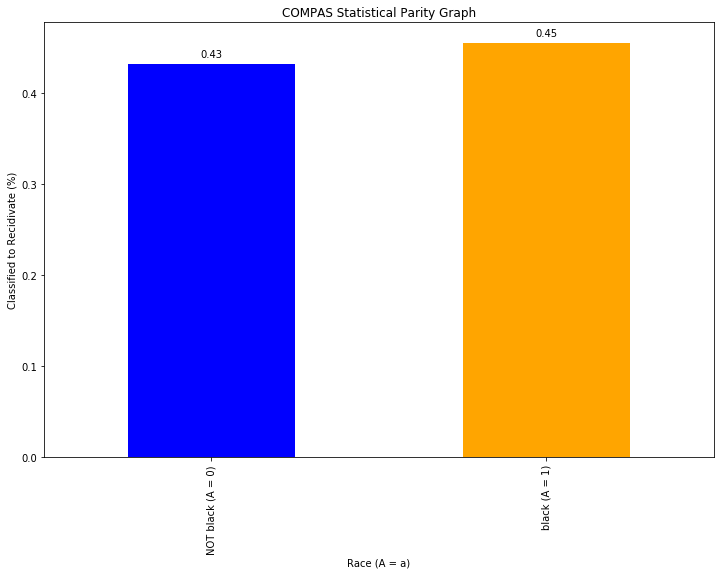

In [28]:
plot_hist(SP_values, SP_labels, 'COMPAS Statistical Parity Graph', 'Race (A = a)', 'Classified to Recidivate (%)')